We will use the [CartPole-v1](https://gym.openai.com/envs/CartPole-v0/) OpenAI Gym environment. For reproducibility, let is fix a random seed.

In [1]:
import pytorch_lightning as pl
from reagent.gym.envs.gym import Gym
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
import tqdm.autonotebook as tqdm

I0224 160042.161 dataclasses.py:48] USE_VANILLA_DATACLASS: True
I0224 160042.162 dataclasses.py:49] ARBITRARY_TYPES_ALLOWED: True
W0224 160042.172 file_io.py:72] ** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

W0224 160042.177 manifold.py:86] ** fvcore version of PathManager will be deprecated soon. **
** Please migrate to iopath. **

I0224 160042.178 io.py:19] Registered Manifold PathManager
W0224 160042.180 manifold.py:86] ** fvcore version of PathManager will be deprecated soon. **
** Please migrate to iopath. **

I0224 160042.180 patch.py:95] Patched torch.load, torch.save, torch.jit.load and save to handle Manifold uri
I0224 160042.333 registry_meta.py:19] Adding REGISTRY to type TrainingReport
I0224 160042.334 registry_meta.py:40] Not Registering TrainingReport to TrainingReport. Abstract method [] are not implemented.
I0224 160042.334 registry_meta.py:19] Adding REGISTRY

In [2]:
env = Gym('CartPole-v0')
env.seed(0)
env.action_space.seed(0)
pl.seed_everything(0)

I0224 160043.363 env_wrapper.py:38] Env: <TimeLimit<CartPoleEnv<CartPole-v0>>>;
observation_space: Box(4,);
action_space: Discrete(2);
I0224 160043.365 seed.py:57] Global seed set to 0


0

The `policy` is composed of a simple scorer (a MLP) and a softmax sampler. Our `agent` simply executes this policy in the CartPole Environment.

In [3]:
from reagent.net_builder.discrete_dqn.fully_connected import FullyConnected
from reagent.gym.utils import build_normalizer

norm = build_normalizer(env)
net_builder = FullyConnected(sizes=[8], activations=["linear"])
cartpole_scorer = net_builder.build_q_network(
    state_feature_config=None, 
    state_normalization_data=norm['state'],
    output_dim=len(norm['action'].dense_normalization_parameters))

I0224 160043.644 registry_meta.py:19] Adding REGISTRY to type DiscreteDQNNetBuilder
I0224 160043.645 registry_meta.py:40] Not Registering DiscreteDQNNetBuilder to DiscreteDQNNetBuilder. Abstract method ['build_q_network'] are not implemented.
I0224 160043.645 registry_meta.py:31] Registering Dueling to DiscreteDQNNetBuilder
I0224 160043.646 dataclasses.py:73] Setting Dueling.__post_init__ to its __post_init_post_parse__
I0224 160043.648 registry_meta.py:31] Registering FullyConnected to DiscreteDQNNetBuilder
I0224 160043.649 dataclasses.py:73] Setting FullyConnected.__post_init__ to its __post_init_post_parse__
I0224 160043.651 registry_meta.py:31] Registering FullyConnectedWithEmbedding to DiscreteDQNNetBuilder
I0224 160043.651 dataclasses.py:73] Setting FullyConnectedWithEmbedding.__post_init__ to its __post_init_post_parse__


In [4]:
from reagent.gym.policies.policy import Policy
from reagent.gym.policies.samplers.discrete_sampler import SoftmaxActionSampler
from reagent.gym.agents.agent import Agent


policy = Policy(scorer=cartpole_scorer, sampler=SoftmaxActionSampler())
agent = Agent.create_for_env(env, policy)

Create a trainer that uses the PPO Algorithm to train.

In [5]:
from reagent.training.ppo_trainer import PPOTrainer
from reagent.optimizer.union import classes


ppo_trainer = PPOTrainer(
    policy=policy,
    gamma=0.99,
    optimizer=classes['Adam'](lr=8e-3, weight_decay=1e-3),
    ppo_epsilon=0.2,
)

RL Interaction Loop

In [6]:
from reagent.gym.runners.gymrunner import evaluate_for_n_episodes
eval_rewards = evaluate_for_n_episodes(100, env, agent, 500, num_processes=20)

I0224 160046.344 gymrunner.py:132] For gamma=1.0, average reward is 18.6
Rewards list: [15. 18. 15. 18. 15. 18. 15. 18. 15. 18. 15. 18. 15. 18. 15. 18. 15. 18.
 15. 18. 15. 18. 15. 18. 15. 18. 15. 18. 15. 18. 15. 18. 15. 18. 15. 18.
 15. 18. 15. 18. 29. 12. 29. 12. 29. 12. 29. 12. 29. 12. 29. 12. 29. 12.
 29. 12. 29. 12. 29. 12. 29. 12. 29. 12. 29. 12. 29. 12. 29. 12. 29. 12.
 29. 12. 29. 12. 29. 12. 29. 12. 17. 21. 17. 21. 17. 21. 17. 21. 17. 21.
 17. 21. 17. 21. 17. 21. 17. 21. 17. 21.]


Run training loop (managed by Pytorch Lightning)

In [7]:
pl.seed_everything(0)

I0224 160048.628 seed.py:57] Global seed set to 0


0

In [8]:
num_episodes = 75
max_steps = 200
reward_decay = 0.8

In [9]:
from reagent.gym.datasets.episodic_dataset import EpisodicDataset, EpisodicDatasetDataloader

pl_trainer = pl.Trainer(max_epochs=1, deterministic=True)
dataset = EpisodicDataset(env=env, agent=agent, num_episodes=num_episodes, seed=0, max_steps=max_steps)

train_rewards = []
class TrainRewardsExtractor(EpisodicDataset):
    # a wrapper around a dataset to enable logging of rewards during training
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __iter__(self):
        for traj in iter(self.dataset):
            ep_reward = traj["reward"].sum().item()
            train_rewards.append(ep_reward)
            yield traj
            
    def __getattr__(self, name):
        return getattr(self.dataset, name)
    
dataset = TrainRewardsExtractor(dataset)

dataloader = EpisodicDatasetDataloader(dataset, num_episodes_between_updates=1, batch_size=1, num_epochs=2)

I0224 160049.000 distributed.py:54] GPU available: False, used: False
I0224 160049.001 distributed.py:54] TPU available: None, using: 0 TPU cores


In [10]:
pl_trainer.fit(ppo_trainer, dataloader)

I0224 160049.195 lightning.py:1381] 
  | Name   | Type              | Params
---------------------------------------------
0 | scorer | FullyConnectedDQN | 58    
---------------------------------------------
58        Trainable params
0         Non-trainable params
58        Total params


Epoch 0: 100%|██████████| 150/150 [00:11<00:00, 13.52it/s, loss=-0.047, v_num=50]  


1

Plot the rewards over training episodes.

(<Figure size 864x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4df4e8dad0>)

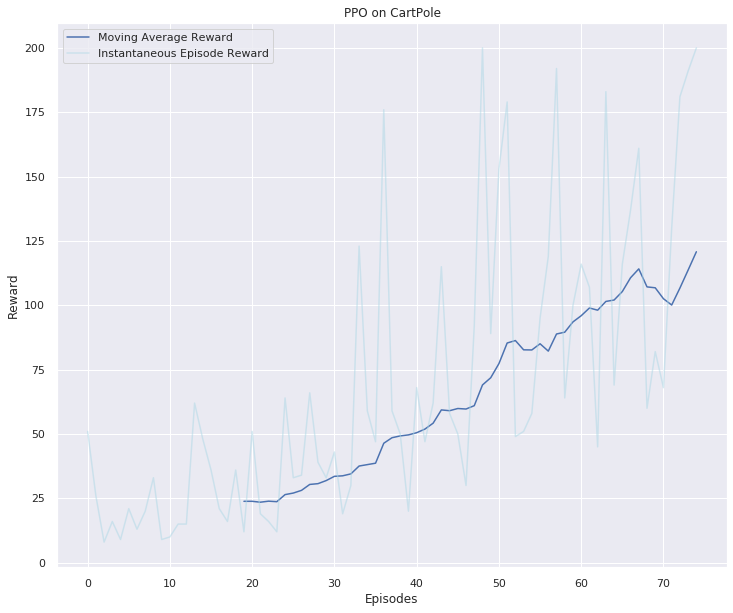

In [11]:
def plot_rewards(rewards):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10));
    pd.Series(rewards).rolling(20).mean().plot(ax=ax);
    pd.Series(rewards).plot(ax=ax,alpha=0.5,color='lightblue');
    ax.set_xlabel('Episodes');
    ax.set_ylabel('Reward');
    plt.title('PPO on CartPole');
    plt.legend(['Moving Average Reward', 'Instantaneous Episode Reward'])
    return fig, ax

sns.set_style('darkgrid')
sns.set()


plot_rewards(train_rewards)

Print eval rewards

In [12]:
eval_episodes = 200
eval_rewards = evaluate_for_n_episodes(eval_episodes, env, agent, 500, num_processes=1).T[0]
mean_reward = pd.Series(eval_rewards).mean()
print(f'Mean reward: {mean_reward:.2f}')

I0224 160212.086 gymrunner.py:132] For gamma=1.0, average reward is 187.87
Rewards list: [200. 190. 190. 200. 200. 200. 187. 188. 198. 200. 200. 200. 200. 165.
 169. 200. 200. 153. 200. 176. 200. 200. 200. 161. 200. 200. 200. 200.
 200. 200. 200. 170. 189. 138. 200. 200. 200. 183. 200. 154. 200. 134.
 194. 178. 180. 170. 200. 162. 168. 200. 176. 155. 200. 182. 200. 200.
 200. 186. 169. 178. 150. 200. 178. 172. 154. 200. 200. 200. 154. 200.
 200. 192. 195. 155. 200. 200. 200. 200. 200. 157. 136. 200. 200. 200.
 200. 172. 200. 200. 200. 171. 200. 200. 157. 193. 145. 200. 200. 200.
 200. 200. 200. 200. 172. 200. 155. 200. 131. 200. 200. 200. 178. 162.
 184. 200. 200. 200. 175. 200. 200. 200. 200. 200. 200. 134. 200. 200.
 146. 200. 200. 191. 200. 200. 200. 200. 150. 194. 200. 200. 200. 200.
 158. 131. 161. 200. 200. 200. 165. 200. 114. 200. 200. 200. 175. 200.
 200. 200. 200. 123. 200. 195. 197. 200. 193. 200. 200. 200. 200. 200.
 200. 200. 181. 200. 190. 191. 125. 165. 200. 200. 200. 200

Mean reward: 187.87
